# 1. Install Dependencies and Setup

In [1]:
import os 
import cv2
import numpy as np
import tensorflow as tf 
from keras.preprocessing.image import ImageDataGenerator 
from keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.layers import Dense, Flatten, Dropout
from keras import Model
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout, BatchNormalization,MaxPool2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# 2. Load Data

In [10]:
train_dir = 'archive/train'
validation_dir = 'archive/valid'
test_dir = "archive/test"

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 1, width_shift_range = 0.01, height_shift_range = 0.02, shear_range = 0.0, zoom_range = 0.2, horizontal_flip = False, fill_mode = 'nearest')

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [18]:
batch_s = 250
image_size = 160

In [19]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = batch_s, class_mode = 'sparse', target_size = (image_size,image_size), shuffle=True, seed=60 , color_mode='rgb')

Found 13492 images belonging to 100 classes.


In [20]:
validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = batch_s, class_mode = 'sparse', target_size = (image_size,image_size),shuffle=False, seed=60 , color_mode='rgb')

Found 500 images belonging to 100 classes.


In [21]:
test_generator = test_datagen.flow_from_directory( test_dir,  batch_size = batch_s, class_mode = 'sparse', target_size = (image_size,image_size),shuffle=False, seed=60 , color_mode='rgb')

Found 500 images belonging to 100 classes.


In [16]:
print(len(train_generator))
print(len(validation_generator))
print(len(test_generator))

54
2
2


In [55]:
batch = train_generator.next()

In [56]:
print('Batch shape:', batch[0].shape)

Batch shape: (250, 160, 160, 3)


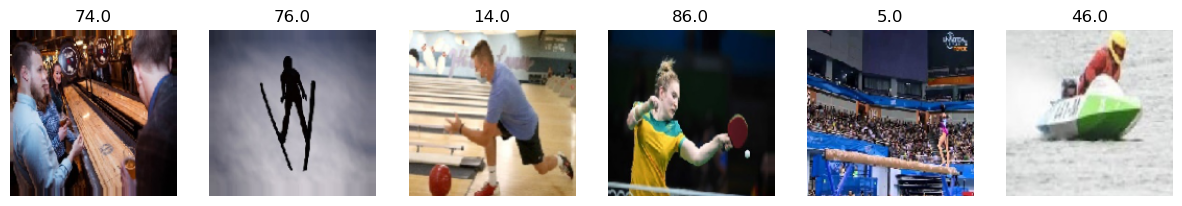

In [57]:
fig, ax = plt.subplots(ncols=6, figsize=(15,15))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis('off')

# 3. Build Deep Learning Model

In [4]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(image_size,image_size, 3)),
   # Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Flatten(),
    Dense(256,kernel_regularizer=l2(0.001), activation='relu'),
   # Dense(128,kernel_regularizer=l2(0.01), activation='relu'),
    Dense(100, activation='softmax')
])


In [5]:
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer=Adam(learning_rate=0.01),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 40, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0

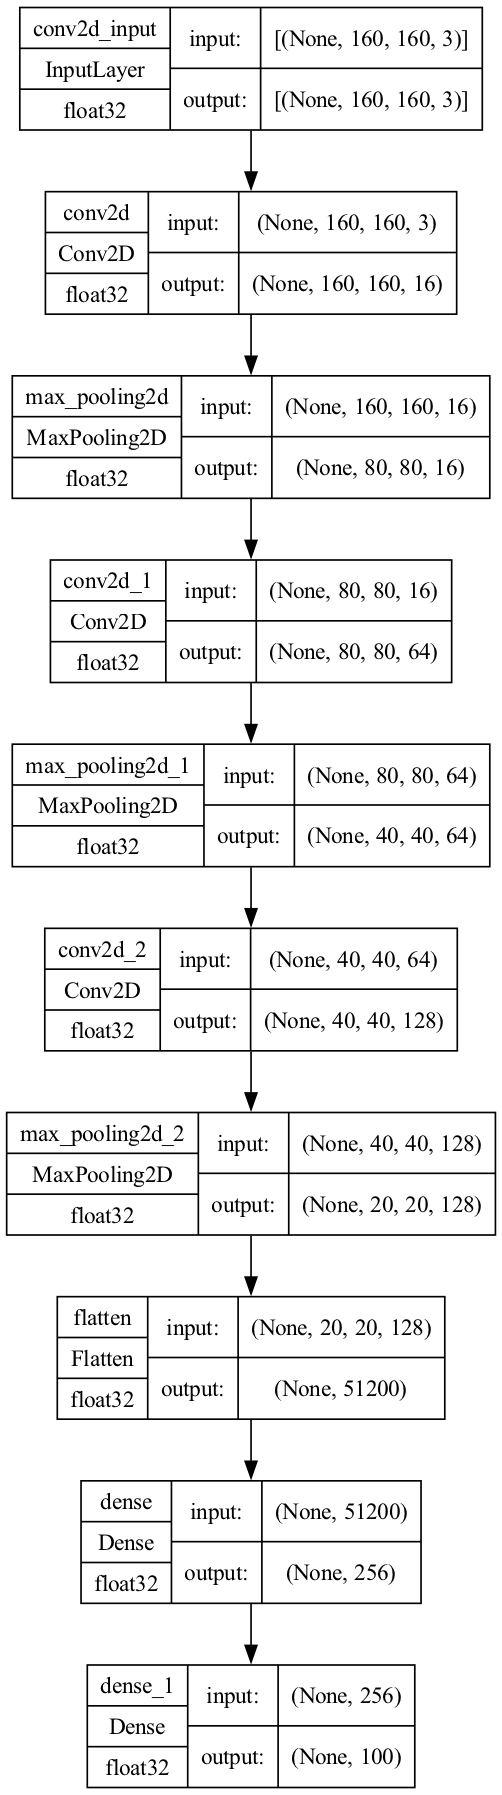

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True,show_dtype=True, show_layer_names=True, dpi=120)

# 4. Train

In [76]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, verbose=1)

In [77]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)


{0: 1.2046428571428571, 1: 1.2046428571428571, 2: 1.0221212121212122, 3: 1.3628282828282827, 4: 1.1939823008849557, 5: 0.9178231292517007, 6: 1.096910569105691, 7: 0.7754022988505748, 8: 0.7983431952662722, 9: 1.2492592592592593, 10: 1.2265454545454546, 11: 0.9304827586206896, 12: 0.9637142857142857, 13: 0.9776811594202899, 14: 1.1243333333333334, 15: 1.163103448275862, 16: 0.905503355704698, 17: 1.07936, 18: 0.8226829268292682, 19: 1.0299236641221374, 20: 1.1243333333333334, 21: 1.0458914728682172, 22: 1.006865671641791, 23: 0.9568794326241135, 24: 1.096910569105691, 25: 0.9994074074074074, 26: 0.8593630573248408, 27: 1.0540625, 28: 0.8935099337748345, 29: 0.8593630573248408, 30: 1.006865671641791, 31: 0.7063874345549738, 32: 0.7101052631578947, 33: 1.0299236641221374, 34: 1.1433898305084746, 35: 0.8994666666666666, 36: 0.8593630573248408, 37: 1.1059016393442622, 38: 1.1150413223140496, 39: 0.9178231292517007, 40: 0.8539240506329114, 41: 0.7844186046511628, 42: 1.006865671641791, 43: 

In [78]:
hist = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=26,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    callbacks=[tensorboard_callback, early_stopping,lr_scheduler],
                    class_weight=class_weights_dict
                )

Epoch 1/26
53/53 [==============================] - 52s 972ms/step - loss: 4.5996 - accuracy: 0.0403 - val_loss: 4.0738 - val_accuracy: 0.0940 - lr: 0.0010
Epoch 2/26
53/53 [==============================] - 51s 968ms/step - loss: 3.6720 - accuracy: 0.1656 - val_loss: 3.4258 - val_accuracy: 0.2020 - lr: 0.0010
Epoch 3/26
53/53 [==============================] - 51s 969ms/step - loss: 3.1392 - accuracy: 0.2760 - val_loss: 2.9367 - val_accuracy: 0.2900 - lr: 0.0010
Epoch 4/26
53/53 [==============================] - 51s 968ms/step - loss: 2.8341 - accuracy: 0.3515 - val_loss: 2.9871 - val_accuracy: 0.3120 - lr: 0.0010
Epoch 5/26
53/53 [==============================] - 52s 970ms/step - loss: 2.5804 - accuracy: 0.4147 - val_loss: 2.7795 - val_accuracy: 0.3700 - lr: 0.0010
Epoch 6/26
53/53 [==============================] - 51s 966ms/step - loss: 2.3944 - accuracy: 0.4581 - val_loss: 2.7808 - val_accuracy: 0.3700 - lr: 0.0010
Epoch 7/26
53/53 [==============================] - 52s 967ms/st

# 5. Plot Performance

In [79]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


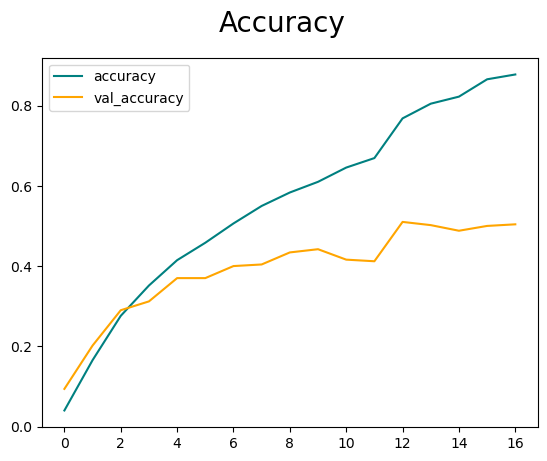

In [80]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

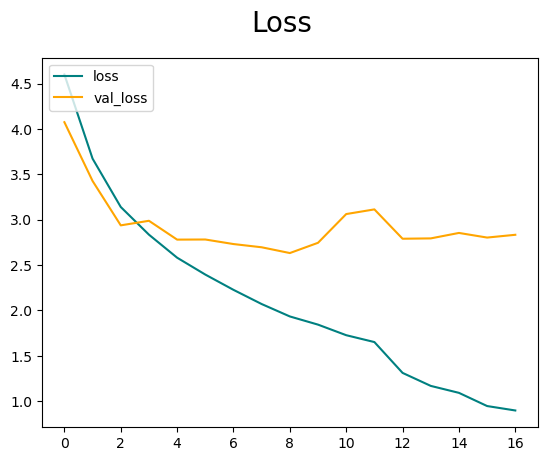

In [81]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 6. Evaluate

In [22]:
# Evaluate the model on Train, Validation and Test data
evaluation = model.evaluate(train_generator)
print(f"Train Loss: {evaluation[0]:.4f}")
print(f"Train Accuracy: {evaluation[1]:.4f}")


evaluation2 = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation2[0]:.4f}")
print(f"Validation Accuracy: {evaluation2[1]:.4f}")

evaluation3 = model.evaluate(test_generator)
print(f"Validation Loss: {evaluation3[0]:.4f}")
print(f"Validation Accuracy: {evaluation3[1]:.4f}")


54/54 [==============================] - 61s 1s/step - loss: 0.8382 - accuracy: 0.7749
Train Loss: 0.8382
Train Accuracy: 0.7749
2/2 [==============================] - 2s 930ms/step - loss: 2.3655 - accuracy: 0.4740
Validation Loss: 2.3655
Validation Accuracy: 0.4740
2/2 [==============================] - 2s 894ms/step - loss: 2.1835 - accuracy: 0.5180
Validation Loss: 2.1835
Validation Accuracy: 0.5180


In [23]:
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = train_generator.classes

print("\nClassification Report On Train:")
print(classification_report(y_true, y_pred_classes, zero_division=0))

54/54 [==============================] - 64s 1s/step

Classification Report On Train:
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       112
           1       0.01      0.01      0.01       112
           2       0.02      0.02      0.02       132
           3       0.00      0.00      0.00        99
           4       0.02      0.03      0.03       113
           5       0.01      0.01      0.01       147
           6       0.02      0.02      0.02       123
           7       0.01      0.01      0.01       174
           8       0.01      0.01      0.01       169
           9       0.01      0.01      0.01       108
          10       0.00      0.00      0.00       110
          11       0.02      0.02      0.02       145
          12       0.02      0.02      0.02       140
          13       0.01      0.01      0.01       138
          14       0.00      0.00      0.00       120
          15       0.01      0.01      0.01      

In [24]:
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

print("\nClassification Report On Validation:")
print(classification_report(y_true, y_pred_classes, zero_division=0))

2/2 [==============================] - 2s 892ms/step

Classification Report On Validation:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      0.20      0.33         5
           2       0.17      0.20      0.18         5
           3       1.00      1.00      1.00         5
           4       0.75      0.60      0.67         5
           5       0.17      0.20      0.18         5
           6       0.80      0.80      0.80         5
           7       0.20      0.20      0.20         5
           8       0.38      0.60      0.46         5
           9       1.00      0.40      0.57         5
          10       0.50      0.20      0.29         5
          11       1.00      0.80      0.89         5
          12       0.33      0.20      0.25         5
          13       0.20      0.20      0.20         5
          14       0.67      0.40      0.50         5
          15       0.67      0.80      0.73 

In [25]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

print("\nClassification Report On Test:")
print(classification_report(y_true, y_pred_classes, zero_division=0))

2/2 [==============================] - 2s 905ms/step

Classification Report On Test:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.50      0.20      0.29         5
           2       0.33      0.40      0.36         5
           3       1.00      0.80      0.89         5
           4       0.67      0.40      0.50         5
           5       0.60      0.60      0.60         5
           6       1.00      0.60      0.75         5
           7       0.14      0.20      0.17         5
           8       0.75      0.60      0.67         5
           9       0.40      0.40      0.40         5
          10       0.25      0.40      0.31         5
          11       0.80      0.80      0.80         5
          12       0.17      0.20      0.18         5
          13       0.38      0.60      0.46         5
          14       0.33      0.20      0.25         5
          15       1.00      0.60      0.75       


Confusion Matrix:


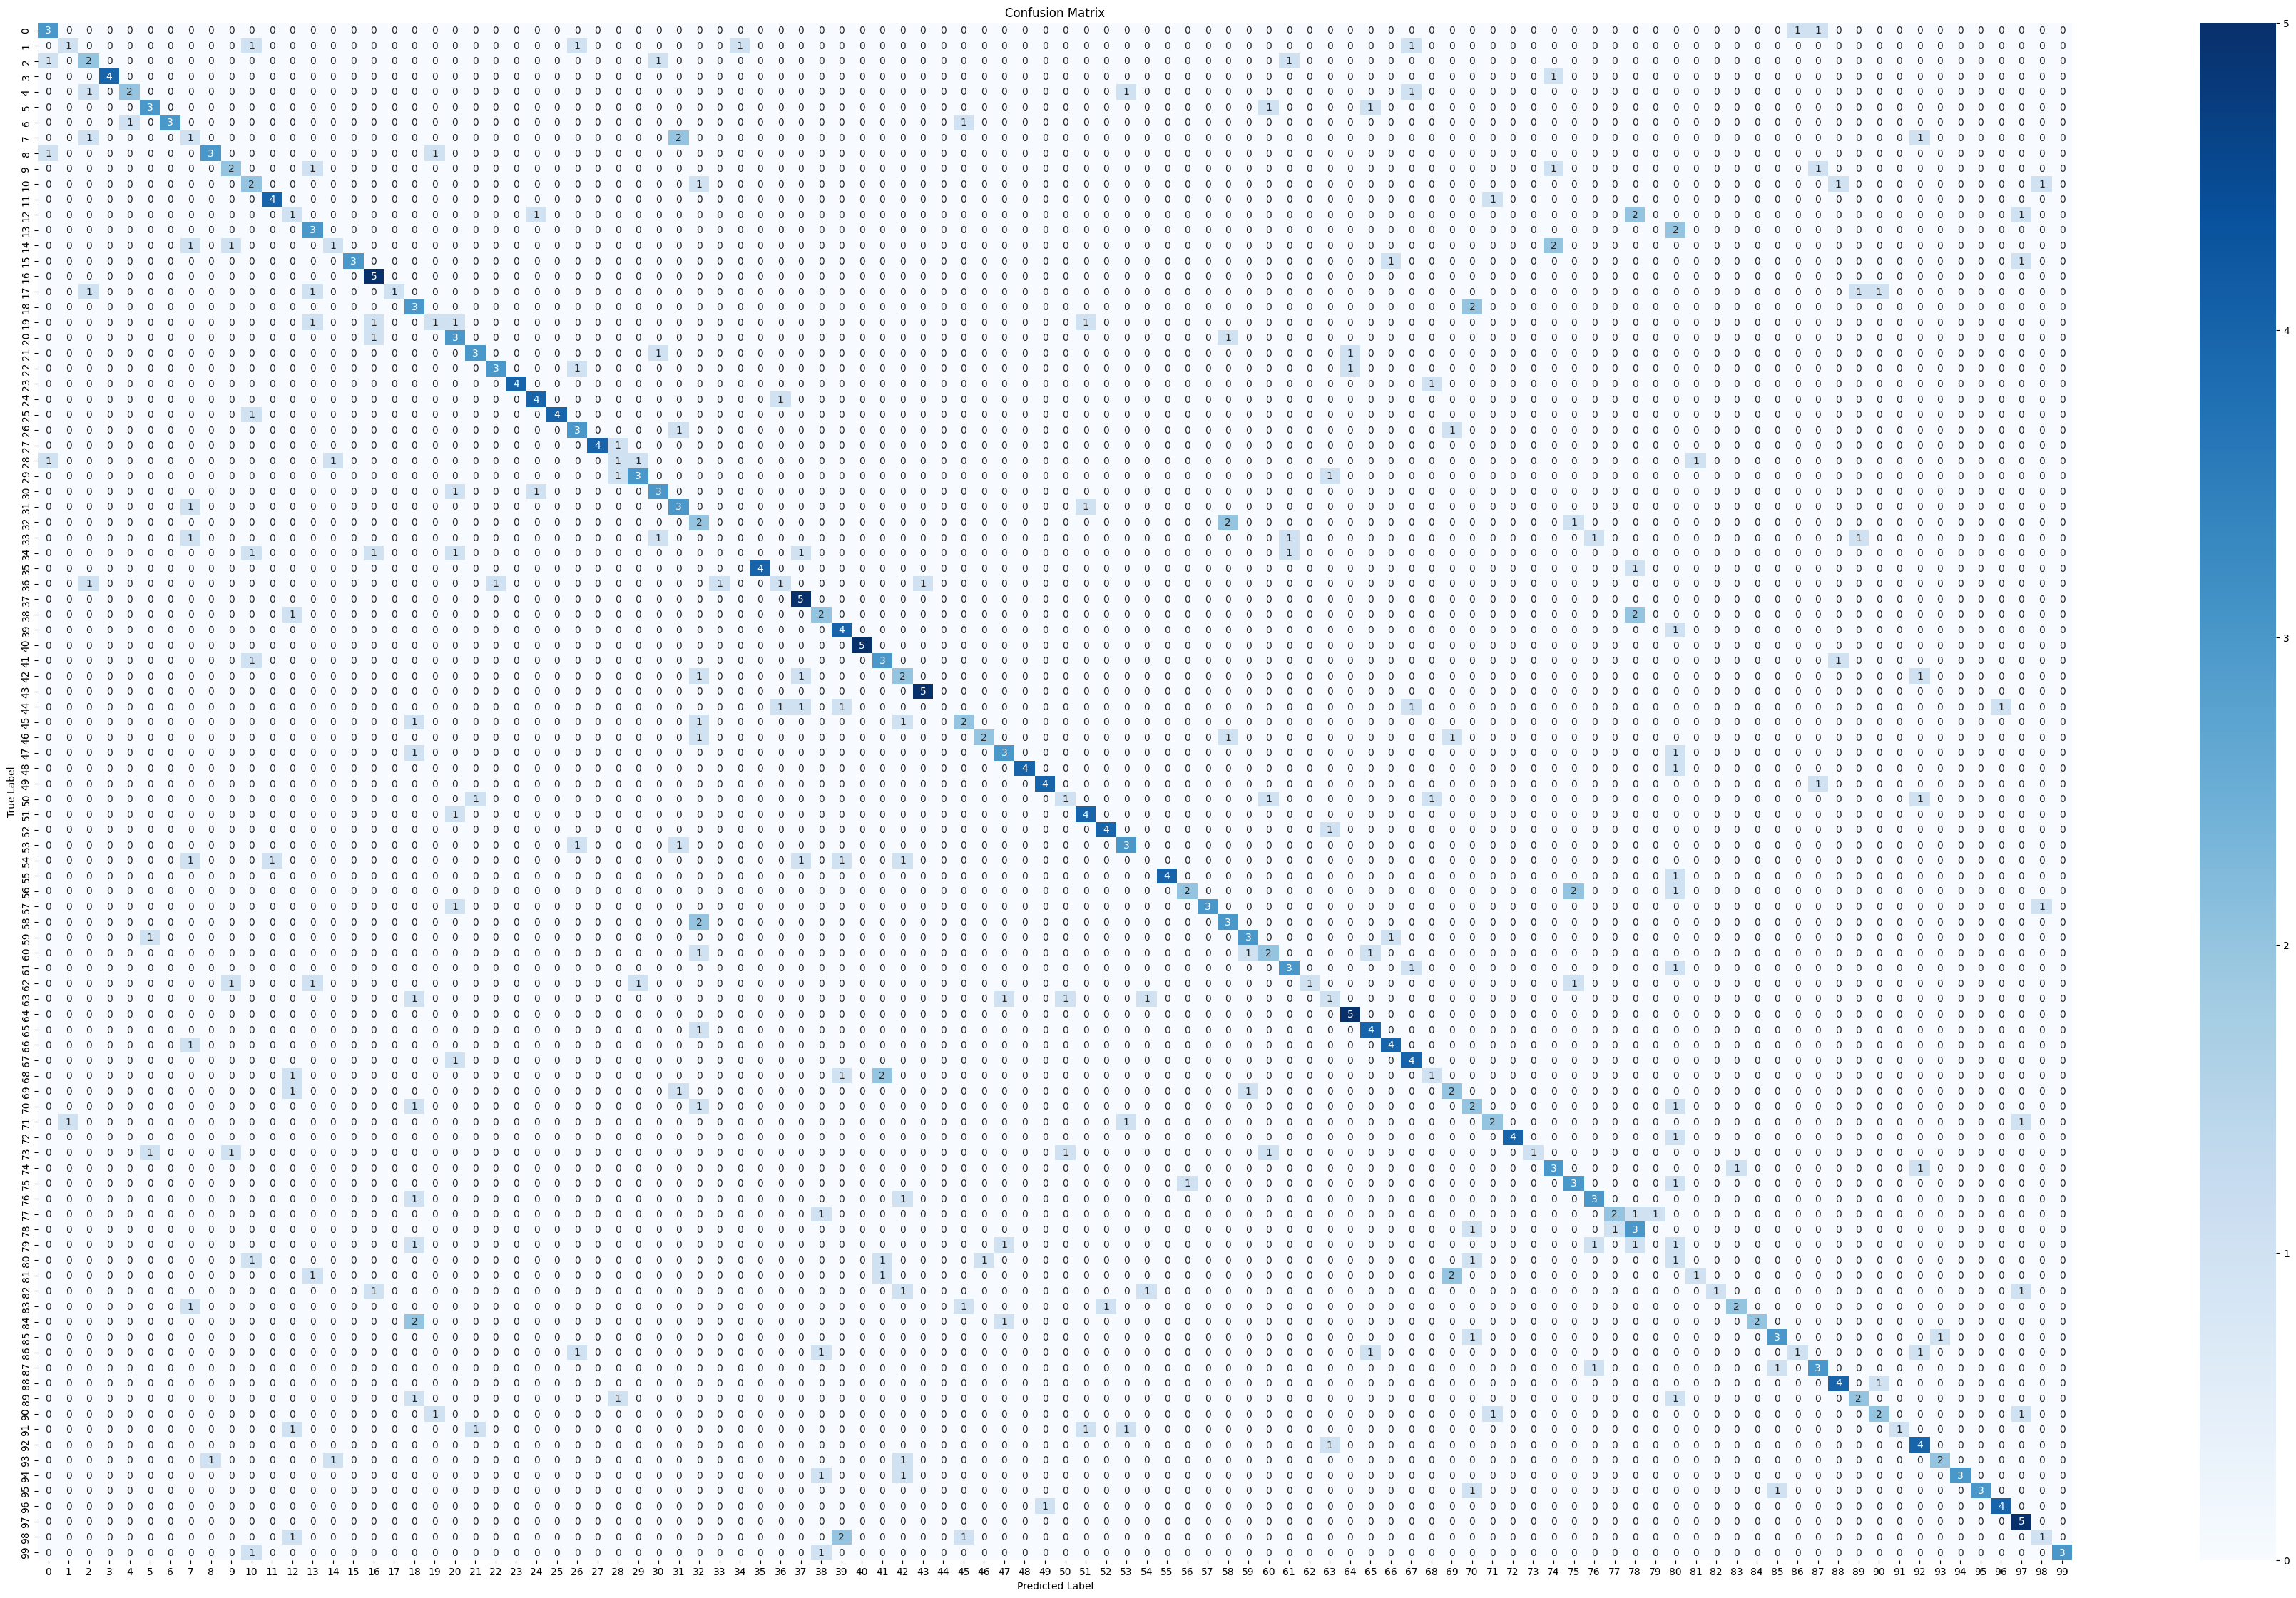

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")

# Visualize confusion matrix
plt.figure(figsize=(46,28))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 7. Is the performance equally good in all the classes? Which classes are underforming and why?


##### The model shows steady improvement in training accuracy, reaching around 87% by epoch 17. However, the validation accuracy stagnates at around 50%, indicating potential overfitting. The validation loss initially decreases but begins increasing after epoch 10, confirming this overfitting pattern. Despite achieving 77.49% accuracy on the training set, the model's performance on validation (47.40%) and test sets (51.80%) reveals a clear gap, further emphasizing its inability to generalize beyond the training data.While precision, recall, and F1-scores are low across all classes in training, they improve slightly in validation and test results. This suggests that the model struggles to classify specific classes, likely due to dataset imbalances and issues with model complexity relative to the task and for overfitting also. Upon closer inspection of the model's performance across all 100 sports categories, it's clear that certain classes are underperforming significantly.Classes with fewer representative images(less data), or those with highly complex or subtle features (such as sports that involve similar equipment or environments), are particularly challenging for the model. For example, categories with sports like fencing or swimming may perform better due to distinct visual cues, whereas more small categories like track events or team sports might exhibit worse performance due to overlapping visual features. These variations highlight the need for either more balanced data or model adjustments to better capture the specific characteristics of these underperforming classes.

# 8.Save Model

In [87]:
#model.save(os.path.join('models','model2.h5'))

In [266]:
#new_model = load_model(os.path.join('models','model1.h5'))

In [27]:
# test_results = new_model.evaluate(test_generator)

# print("Test Loss:", test_results[0])
# print("Test Accuracy:", test_results[1])

# 8.Test Visualization

In [29]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = test_generator.classes



2/2 [==============================] - 3s 958ms/step


In [30]:
correct_indices = np.where(predicted_classes == actual_classes)[0]
incorrect_indices = np.where(predicted_classes != actual_classes)[0]

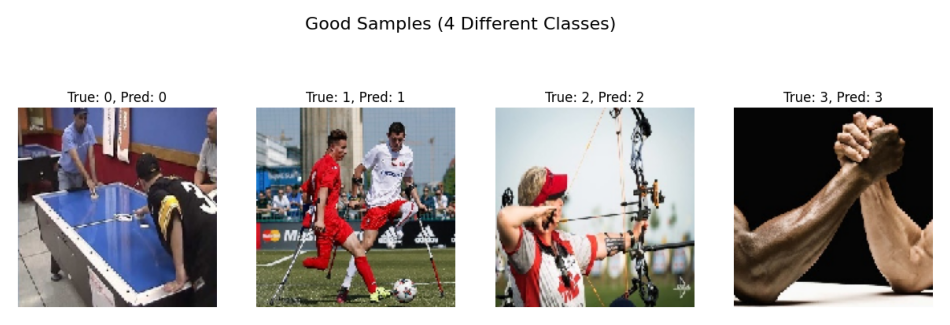

In [51]:
img = cv2.imread('Good_samples.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,26))
plt.imshow(img_rgb)
plt.axis('off')  
plt.show()

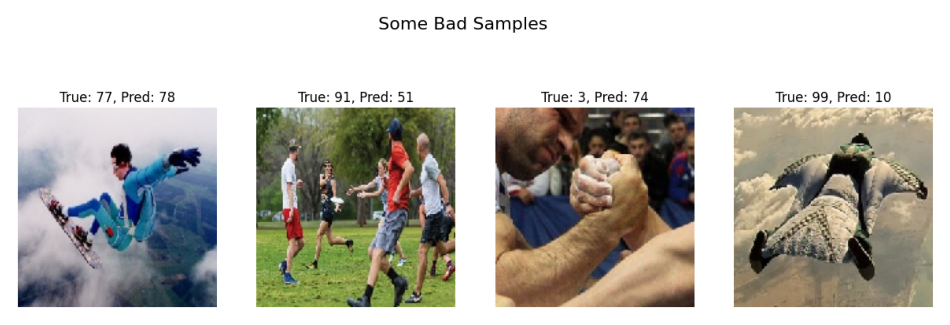

In [52]:
img = cv2.imread('Bad_samples.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,26))
plt.imshow(img_rgb)
plt.axis('off')  
plt.show()

##### In the bad samples, we can observe a few key factors contributing to the misclassifications for classes 77, 91, 3, and 99. Firstly, there is an imbalance in the training set, with fewer images for these specific classes. Class 91 represents a team sport, making it harder for the model to classify accurately due to the presence of multiple people in the images. For classes 77 and 99, the primary focus of the images might be on the sky, which looks similar across both classes, making it difficult for the model to generalize and distinguish key features. In class 3, there is another hand visible in the foreground, which may confuse the model and prevent it from learning the main subject properly. Overall, the combination of data imbalance and these visual challenges contributes to the poor performance in these cases.